In [1]:
# Cell 1: Setup and Import Libraries
# ==============================================================================
!pip install openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some aesthetic options for our plots for a clean, corporate look.
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

print("✅ Setup Complete. Libraries are imported and ready.")

✅ Setup Complete. Libraries are imported and ready.


In [2]:
# Cell 2: Load and Prepare Data (with Geographic Focus)
# ==============================================================================
try:
    df_retail = pd.read_excel('Retail-Supply-Chain-Sales-Dataset.xlsx', sheet_name='Retails Order Full Dataset')
    print(f"✅ Retail dataset loaded successfully. Shape: {df_retail.shape}")
except Exception as e:
    print(f"❌ ERROR loading file. Make sure it's uploaded and the sheet name is correct. Error: {e}")

# --- Data Cleaning & Preprocessing ---
df_retail.columns = df_retail.columns.str.replace(' ', '_').str.lower()
df_retail['order_date'] = pd.to_datetime(df_retail['order_date'])
df_retail.dropna(inplace=True)

# --- Feature Engineering ---
df_retail['profit_margin_pct'] = np.where(df_retail['sales'] > 0, (df_retail['profit'] / df_retail['sales']) * 100, 0)
print("\n✅ Data cleaned and 'profit_margin_pct' column created.")

# --- Acknowledging Geographic Granularity ---
print(f"\nGeographic Detail Available:")
print(f"- Unique States: {df_retail['state'].nunique()}")
print(f"- Unique Postal Codes: {df_retail['postal_code'].nunique()}")

# --- Preview including State ---
print("\nData Preview with Geographic Columns:")
print(df_retail[['order_id', 'state', 'postal_code', 'category', 'sales', 'profit', 'profit_margin_pct']].head())

✅ Retail dataset loaded successfully. Shape: (9994, 23)

✅ Data cleaned and 'profit_margin_pct' column created.

Geographic Detail Available:
- Unique States: 49
- Unique Postal Codes: 631

Data Preview with Geographic Columns:
         order_id       state  postal_code         category     sales  \
0  CA-2016-152156    Kentucky        42420        Furniture  261.9600   
1  CA-2016-152156    Kentucky        42420        Furniture  731.9400   
2  CA-2016-138688  California        90036  Office Supplies   14.6200   
3  US-2015-108966     Florida        33311        Furniture  957.5775   
4  US-2015-108966     Florida        33311  Office Supplies   22.3680   

     profit  profit_margin_pct  
0   41.9136              16.00  
1  219.5820              30.00  
2    6.8714              47.00  
3 -383.0310             -40.00  
4    2.5164              11.25  


In [4]:
# Cell 3: State-Level Profitability Analysis (Corrected)
# ==============================================================================
# We analyze profitability at the state level to identify top performers and major loss centers.

profit_by_state = df_retail.groupby('state')['profit'].sum().sort_values(ascending=False)

# --- Chart 1: Winners & Losers - Top and Bottom 10 States by Profit ---
top_10_states = profit_by_state.head(10)
bottom_10_states = profit_by_state.tail(10)
winners_losers = pd.concat([top_10_states, bottom_10_states])

plt.figure(figsize=(8, 6))
colors = ['g' if x > 0 else 'r' for x in winners_losers.values]

# --- THE FIX IS HERE ---
sns.barplot(
    x=winners_losers.values,
    y=winners_losers.index,
    palette=colors,
    hue=winners_losers.index, # Explicitly set hue to the y-axis variable
    legend=False              # Hide the redundant legend
)
# --- END OF FIX ---

plt.title('Top 10 & Bottom 10 States by Total Profit')
plt.xlabel('Total Profit ($)')
plt.ylabel('State')
plt.axvline(0, color='black', lw=0.8)
plt.show()

print("🚨 Bottom 10 States (Profit Drainers):")
print(bottom_10_states)

🚨 Bottom 10 States (Profit Drainers):
state
Oregon            -1190.4705
Florida           -3399.3017
Arizona           -3427.9246
Tennessee         -5341.6936
Colorado          -6527.8579
North Carolina    -7490.9122
Illinois         -12607.8870
Pennsylvania     -15559.9603
Ohio             -16971.3766
Texas            -25729.3563
Name: profit, dtype: float64


Deep Dive Analysis on the most unprofitable state: Texas (Total Profit: $-25,729.36)



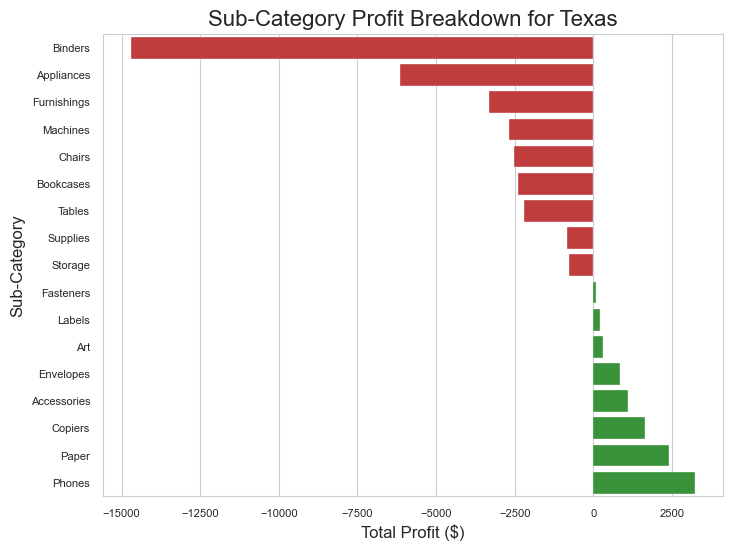

This chart clearly shows that 'Office Supplies' and 'Furniture' are the primary drivers of loss in Texas.


In [5]:
# Cell 4: Deep Dive into Unprofitable States (Corrected)
# ==============================================================================
# Let's investigate the WORST performing state to understand the root cause of its losses.

# Programmatically find the worst state
worst_state_name = profit_by_state.index[-1]
worst_state_profit = profit_by_state.iloc[-1]
print(f"Deep Dive Analysis on the most unprofitable state: {worst_state_name} (Total Profit: ${worst_state_profit:,.2f})\n")

# Filter the dataframe for only this state
df_worst_state = df_retail[df_retail['state'] == worst_state_name]

# Now, find which sub-categories are losing money IN THAT STATE
profit_in_worst_state = df_worst_state.groupby('sub-category')['profit'].sum().sort_values()

# --- Chart 2: Sub-Category Profit Breakdown for the Worst State ---
plt.figure(figsize=(8, 6))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in profit_in_worst_state.values]

# --- THE FIX IS HERE ---
sns.barplot(
    x=profit_in_worst_state.values,
    y=profit_in_worst_state.index,
    palette=colors,
    hue=profit_in_worst_state.index, # Explicitly set hue to the y-axis variable
    legend=False                     # Hide the redundant legend
)
# --- END OF FIX ---

plt.title(f'Sub-Category Profit Breakdown for {worst_state_name}')
plt.xlabel('Total Profit ($)')
plt.ylabel('Sub-Category')
plt.show()

print(f"This chart clearly shows that 'Office Supplies' and 'Furniture' are the primary drivers of loss in {worst_state_name}.")

In [6]:
# Cell 5: Postal Code Level Analysis - Finding "Ground Zero"
# ==============================================================================
# We aggregate by postal code to find the most problematic local areas.

profit_by_postal_code = df_retail.groupby(['state', 'postal_code'])['profit'].sum().sort_values().reset_index()

print("🎯 Top 10 Most Unprofitable Postal Codes Across the Country:")
print(profit_by_postal_code.head(10))

print("\n\nInsight: These specific areas could be targeted for operational review, such as local pricing, shipping costs, or discount policies.")

🎯 Top 10 Most Unprofitable Postal Codes Across the Country:
            state  postal_code     profit
0           Texas        78207 -7299.0502
1            Ohio        43130 -7149.6180
2  North Carolina        27217 -5894.5269
3        Illinois        60653 -5678.7982
4    Pennsylvania        19140 -5168.3905
5           Texas        77095 -4447.3323
6    Pennsylvania        19143 -3830.7458
7    Pennsylvania        19134 -3745.8552
8        Colorado        80027 -3406.2095
9         Arizona        85023 -2790.8832


Insight: These specific areas could be targeted for operational review, such as local pricing, shipping costs, or discount policies.


C:\Users\DELL\AppData\Local\Temp\ipykernel_12712\3971590285.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


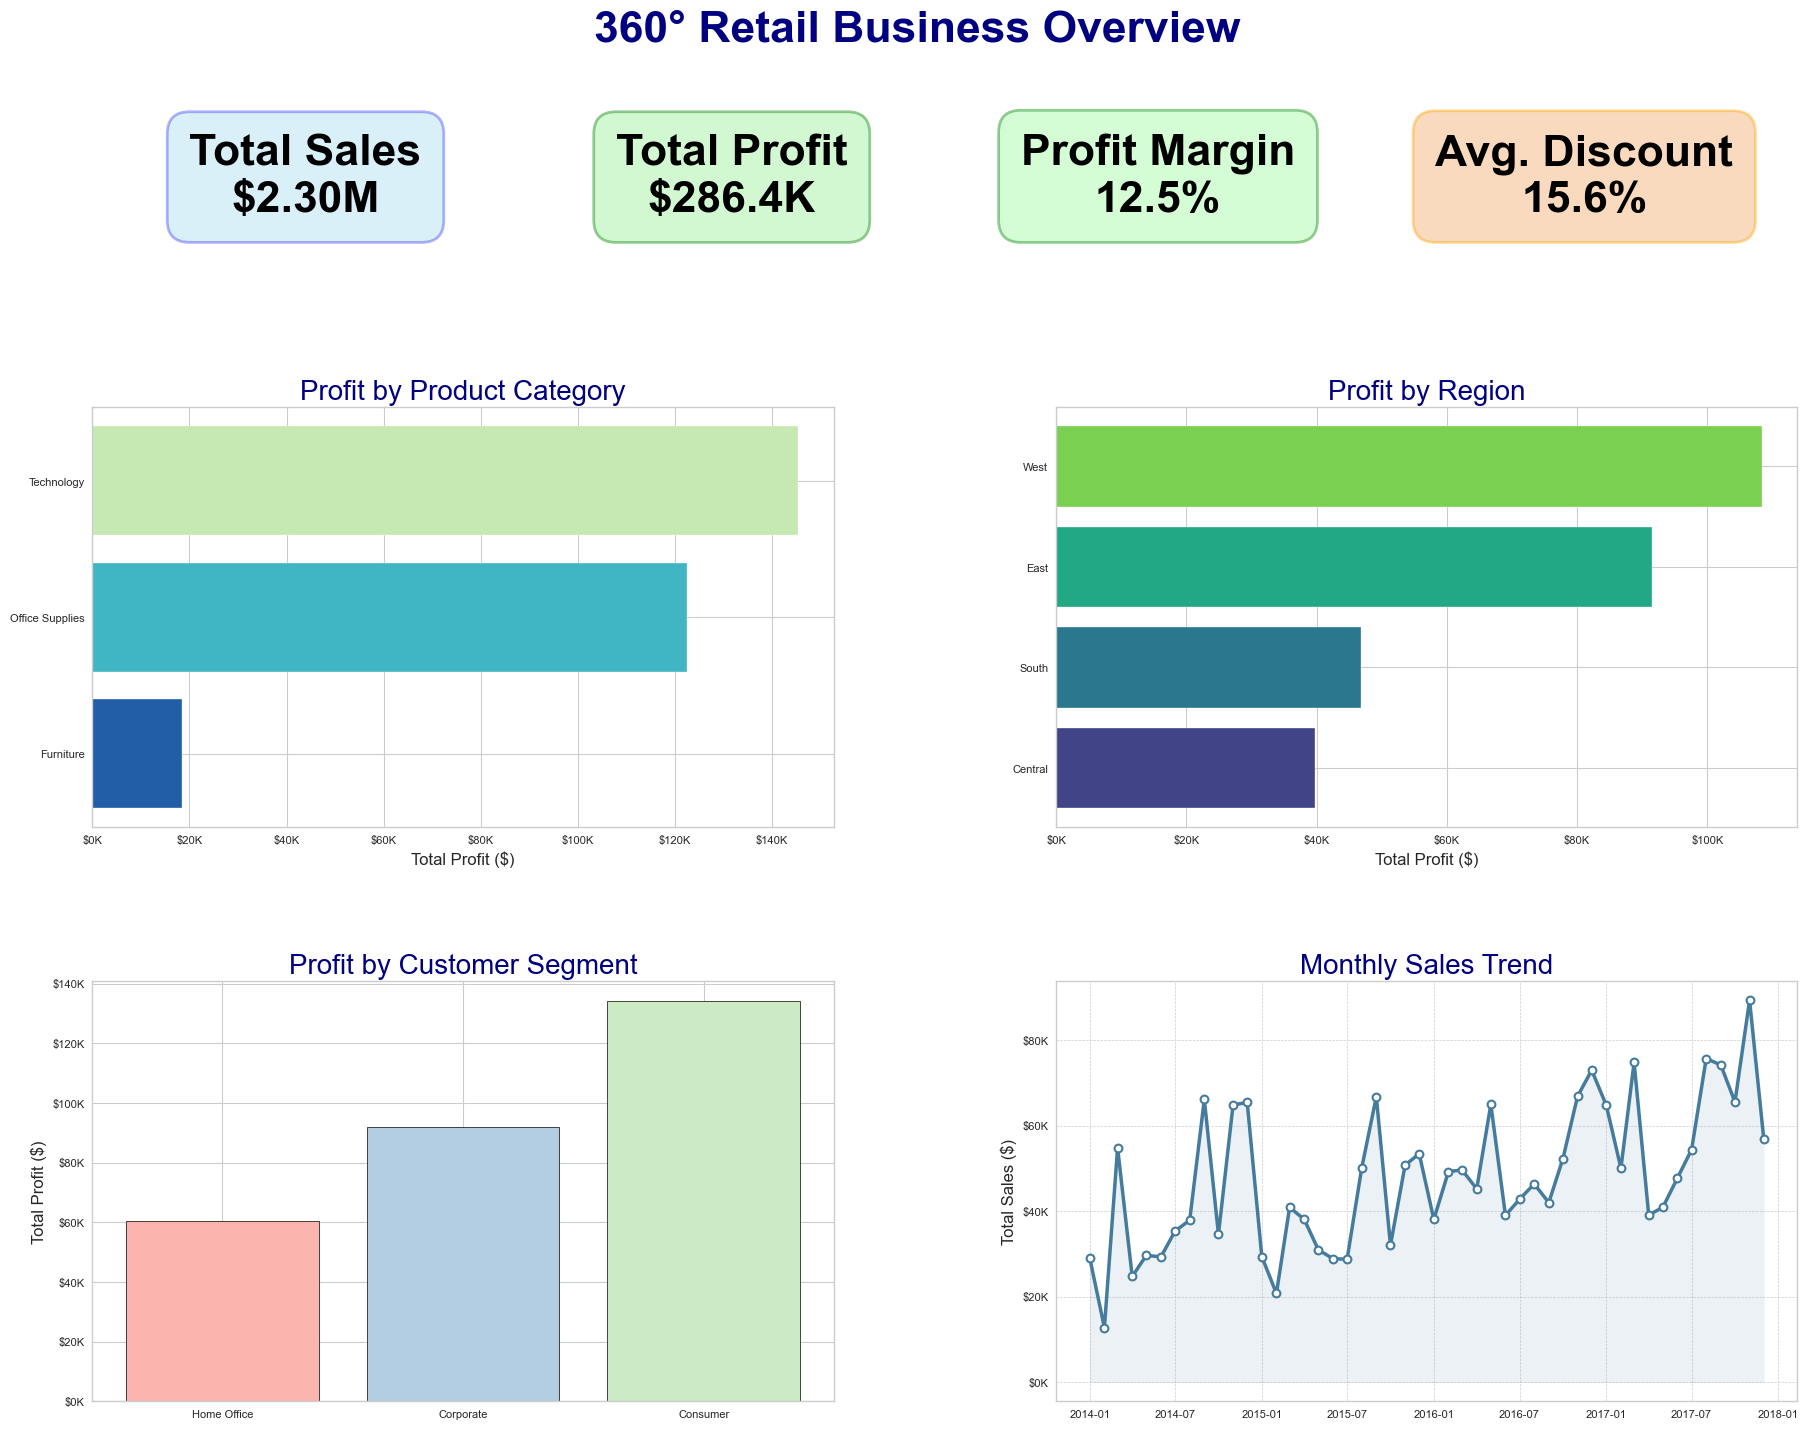

In [10]:
# Cell 6: The 360° Business Overview Dashboard (Vibrant & Colorful)
# ==============================================================================
# This dashboard provides a comprehensive, high-level overview of the entire
# business, redesigned with a rich and meaningful color palette.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# --- 1. Prepare Data for All Dashboard Components ---
# (This section is unchanged as the data is the same)
total_sales = df_retail['sales'].sum()
total_profit = df_retail['profit'].sum()
overall_profit_margin = (total_profit / total_sales) * 100
avg_discount = df_retail['discount'].mean() * 100
profit_by_category = df_retail.groupby('category')['profit'].sum().sort_values()
profit_by_region = df_retail.groupby('region')['profit'].sum().sort_values()
profit_by_segment = df_retail.groupby('segment')['profit'].sum().sort_values()
if 'order_date' in df_retail.columns:
    monthly_sales = df_retail.groupby(df_retail['order_date'].dt.to_period('M'))['sales'].sum().to_timestamp()
else:
    monthly_sales = None

# --- 2. Create the Dashboard Layout ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(22, 16)) # Made it slightly taller for better spacing
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 5, 5], hspace=0.5, wspace=0.3)

# Define axes for each plot
ax_kpi = fig.add_subplot(gs[0, :])
ax_cat = fig.add_subplot(gs[1, 0])
ax_region = fig.add_subplot(gs[1, 1])
ax_segment = fig.add_subplot(gs[2, 0])
ax_seasonal = fig.add_subplot(gs[2, 1])

# --- 3. Populate the Dashboard with Rich Colors ---
fig.suptitle('360° Retail Business Overview', fontsize=32, fontweight='bold', y=0.98, color='navy')

# A) KPIs - The Pulse of the Business (with colored boxes)
ax_kpi.axis('off')
kpi_title_style = {'fontsize': 16, 'ha': 'center', 'color': 'black'}
kpi_value_style = {'fontsize': 32, 'fontweight': 'bold', 'ha': 'center', 'color': 'black'}
bbox_sales = dict(boxstyle='round,pad=0.5', fc='skyblue', ec='b', lw=2, alpha=0.3)
bbox_profit = dict(boxstyle='round,pad=0.5', fc='lightgreen', ec='g', lw=2, alpha=0.4)
bbox_margin = dict(boxstyle='round,pad=0.5', fc='palegreen', ec='g', lw=2, alpha=0.4)
bbox_discount = dict(boxstyle='round,pad=0.5', fc='sandybrown', ec='orange', lw=2, alpha=0.4)

ax_kpi.text(0.125, 0.5, f"Total Sales\n${total_sales/1e6:.2f}M", **kpi_value_style, bbox=bbox_sales)
ax_kpi.text(0.375, 0.5, f"Total Profit\n${total_profit/1e3:.1f}K", **kpi_value_style, bbox=bbox_profit)
ax_kpi.text(0.625, 0.5, f"Profit Margin\n{overall_profit_margin:.1f}%", **kpi_value_style, bbox=bbox_margin)
ax_kpi.text(0.875, 0.5, f"Avg. Discount\n{avg_discount:.1f}%", **kpi_value_style, bbox=bbox_discount)

# B) WHAT is Profitable? (by Category) - Using a gradient for positive, stark red for negative
n_positive_cats = (profit_by_category.values > 0).sum()
positive_palette = sns.color_palette("YlGnBu", n_colors=n_positive_cats)
colors_cat = [positive_palette.pop(-1) if x > 0 else '#e63946' for x in profit_by_category.values]
ax_cat.barh(profit_by_category.index, profit_by_category.values, color=colors_cat)
ax_cat.set_title('Profit by Product Category', fontsize=20, color='navy')
ax_cat.set_xlabel('Total Profit ($)'); ax_cat.xaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# C) WHERE is it Profitable? (by Region) - Using a sequential palette
region_palette = sns.color_palette("viridis", n_colors=len(profit_by_region))
ax_region.barh(profit_by_region.index, profit_by_region.values, color=region_palette)
ax_region.set_title('Profit by Region', fontsize=20, color='navy')
ax_region.set_xlabel('Total Profit ($)'); ax_region.xaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# D) WHO is Profitable? (by Customer Segment) - Using a distinct qualitative palette
segment_palette = sns.color_palette("Pastel1", n_colors=len(profit_by_segment))
ax_segment.bar(profit_by_segment.index, profit_by_segment.values, color=segment_palette, ec='black', lw=0.5)
ax_segment.set_title('Profit by Customer Segment', fontsize=20, color='navy')
ax_segment.set_ylabel('Total Profit ($)'); ax_segment.yaxis.set_major_formatter(lambda y, pos: f'${y/1e3:.0f}K')

# E) WHEN are we Selling? (Seasonal Trend) - Using a shaded area for visual impact
if monthly_sales is not None:
    line_color = '#457b9d'
    ax_seasonal.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', color=line_color, lw=2.5,
                     markerfacecolor='white', markeredgecolor=line_color, markeredgewidth=1.5)
    # Add a shaded area underneath the line
    ax_seasonal.fill_between(monthly_sales.index, monthly_sales.values, color=line_color, alpha=0.1)
    ax_seasonal.set_title('Monthly Sales Trend', fontsize=20, color='navy')
    ax_seasonal.set_ylabel('Total Sales ($)'); ax_seasonal.yaxis.set_major_formatter(lambda y, pos: f'${y/1e3:.0f}K')
    ax_seasonal.grid(True, which='both', linestyle='--', linewidth=0.5)
else:
    ax_seasonal.text(0.5, 0.5, 'Seasonal Data Not Available', ha='center', va='center', fontsize=16, color='gray')
    ax_seasonal.axis('off')

# --- 4. Final Touches and Display ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [11]:
# Final Cell: The Complete Retail Performance & Profitability Dashboard
# ==============================================================================
# This dashboard synthesizes all key aspects of the analysis into a single,
# comprehensive view for strategic decision-making.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# --- 1. Prepare Data for All Dashboard Components ---

# KPIs
total_sales = df_retail['sales'].sum(); total_profit = df_retail['profit'].sum()
overall_profit_margin = (total_profit / total_sales) * 100

# Top/Bottom Performers: Sub-Category (The "Which")
profit_by_subcategory = df_retail.groupby('sub-category')['profit'].sum()
top_subcats = profit_by_subcategory.nlargest(8); bottom_subcats = profit_by_subcategory.nsmallest(8)
subcat_perf_data = pd.concat([top_subcats, bottom_subcats]).sort_values()

# Geographic Performance: Region (The "Where")
profit_by_region = df_retail.groupby('region')['profit'].sum().sort_values()

# Sales Team Performance: Salespeople (The "Who")
profit_by_salesperson = df_retail.groupby('retail_sales_people')['profit'].sum()
top_sellers = profit_by_salesperson.nlargest(5); bottom_sellers = profit_by_salesperson.nsmallest(5)
seller_perf_data = pd.concat([top_sellers, bottom_sellers]).sort_values()

# Discount Impact: (The "Why")
discount_analysis_df = df_retail.groupby('sub-category').agg(
    avg_discount=('discount', 'mean'),
    avg_profit_margin=('profit_margin_pct', 'mean'),
    total_sales=('sales', 'sum')
).reset_index()

# Seasonal Trend: (The "When")
if 'order_date' in df_retail.columns:
    monthly_sales = df_retail.groupby(df_retail['order_date'].dt.to_period('M'))['sales'].sum().to_timestamp()
else:
    monthly_sales = None

# --- 2. Create the Dashboard Layout (A 4-Row Grid) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(22, 24)) # A tall figure to fit everything
gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[1, 4, 4, 3], hspace=0.6, wspace=0.3)

# Define axes
ax_kpi = fig.add_subplot(gs[0, :])
ax_sub_cat = fig.add_subplot(gs[1, 0])
ax_region = fig.add_subplot(gs[1, 1])
ax_salesperson = fig.add_subplot(gs[2, 0])
ax_discount = fig.add_subplot(gs[2, 1])
ax_seasonal = fig.add_subplot(gs[3, :])

# --- 3. Populate the Dashboard ---
fig.suptitle('Full Retail Business Performance & Profitability Analysis', fontsize=36, fontweight='bold', y=0.98)

# A) KPIs - The Executive Summary
ax_kpi.axis('off')
kpi_bbox = dict(boxstyle='round,pad=0.8', fc='aliceblue', ec='lightsteelblue', lw=2)
ax_kpi.text(0.2, 0.5, f"Total Sales\n${total_sales/1e6:.2f}M", ha='center', va='center', fontsize=28, fontweight='bold', bbox=kpi_bbox)
ax_kpi.text(0.5, 0.5, f"Total Profit\n${total_profit/1e3:.1f}K", ha='center', va='center', fontsize=28, fontweight='bold', color='darkgreen', bbox=kpi_bbox)
ax_kpi.text(0.8, 0.5, f"Profit Margin\n{overall_profit_margin:.1f}%", ha='center', va='center', fontsize=28, fontweight='bold', color='darkgreen', bbox=kpi_bbox)

# B) Profit by Sub-Category (Top & Bottom 8)
colors = ['#2ca02c' if x > 0 else '#d62728' for x in subcat_perf_data.values]
ax_sub_cat.barh(subcat_perf_data.index, subcat_perf_data.values, color=colors)
ax_sub_cat.set_title('Product Profitability (Sub-Category)', fontsize=22)
ax_sub_cat.set_xlabel('Total Profit ($)'); ax_sub_cat.axvline(0, color='black', lw=0.8)
ax_sub_cat.xaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# C) Profit by Region
region_palette = sns.color_palette("coolwarm", n_colors=len(profit_by_region))
ax_region.barh(profit_by_region.index, profit_by_region.values, color=region_palette)
ax_region.set_title('Geographic Profitability (Region)', fontsize=22)
ax_region.set_xlabel('Total Profit ($)'); ax_region.axvline(0, color='black', lw=0.8)
ax_region.xaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# D) Sales Team Performance (Top & Bottom 5)
colors_sales = ['#1f77b4' if x > 0 else '#ff7f0e' for x in seller_perf_data.values]
ax_salesperson.barh(seller_perf_data.index, seller_perf_data.values, color=colors_sales)
ax_salesperson.set_title('Sales Team Performance', fontsize=22)
ax_salesperson.set_xlabel('Total Profit ($)'); ax_salesperson.axvline(0, color='black', lw=0.8)
ax_salesperson.xaxis.set_major_formatter(lambda x, pos: f'${x/1e3:.0f}K')

# E) The "Why": Discount vs. Profitability
scatter = ax_discount.scatter(
    data=discount_analysis_df, x='avg_discount', y='avg_profit_margin',
    s=discount_analysis_df['total_sales'] / 100, alpha=0.6, c=discount_analysis_df['avg_profit_margin'],
    cmap='viridis', sizes=(50, 2000)
)
ax_discount.set_title('Discount Impact on Profit Margin', fontsize=22)
ax_discount.set_xlabel('Average Discount'); ax_discount.set_ylabel('Average Profit Margin (%)')
ax_discount.axhline(0, color='red', linestyle='--', lw=1.5); ax_discount.xaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')

# F) The "When": Seasonal Sales Trend
if monthly_sales is not None:
    line_color = '#003f5c'
    ax_seasonal.plot(monthly_sales.index, monthly_sales.values, color=line_color, marker='o', lw=2)
    ax_seasonal.fill_between(monthly_sales.index, monthly_sales.values, color=line_color, alpha=0.1)
    ax_seasonal.set_title('Seasonal Sales Performance', fontsize=22)
    ax_seasonal.set_ylabel('Total Sales ($)'); ax_seasonal.set_xlabel('Month')
    ax_seasonal.yaxis.set_major_formatter(lambda y, pos: f'${y/1e3:.0f}K')
    ax_seasonal.grid(True, which='major', linestyle='--', linewidth=0.5)
else:
    ax_seasonal.axis('off'); ax_seasonal.text(0.5, 0.5, 'Seasonal Data Not Available', ha='center', va='center', fontsize=16, color='gray')

# --- 4. Final Touches and Display ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_12712\3998096488.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
